In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
# Import the Pipeline class from sklearn.pipeline
from sklearn.pipeline import Pipeline

# Load data
data = pd.read_csv('obesity_data.csv')

# Display basic info and statistics to understand the data structure
print(data.info())
print(data.describe())

# Check for missing values in the dataset
print(data.isnull().sum())

# Separate features and target variable
# Assume 'Obesity' is the target variable (change as appropriate based on your data)
X = data.drop("ObesityCategory", axis=1)
y = data["ObesityCategory"]

# Create a ColumnTransformer to apply different preprocessing to numerical and categorical features
# Define numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Use most frequent for categorical
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine the pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Apply the preprocessing to the features
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# The data is now preprocessed and ready for model training


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1000 non-null   int64  
 1   Gender                 1000 non-null   object 
 2   Height                 1000 non-null   float64
 3   Weight                 1000 non-null   float64
 4   BMI                    1000 non-null   float64
 5   PhysicalActivityLevel  1000 non-null   int64  
 6   ObesityCategory        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB
None
               Age       Height       Weight          BMI  \
count  1000.000000  1000.000000  1000.000000  1000.000000   
mean     49.857000   170.052417    71.205769    24.888317   
std      18.114267    10.309971    15.509849     6.193912   
min      18.000000   136.115719    26.065730     8.470572   
25%      35.000000   163.514205    61.129629    20.918

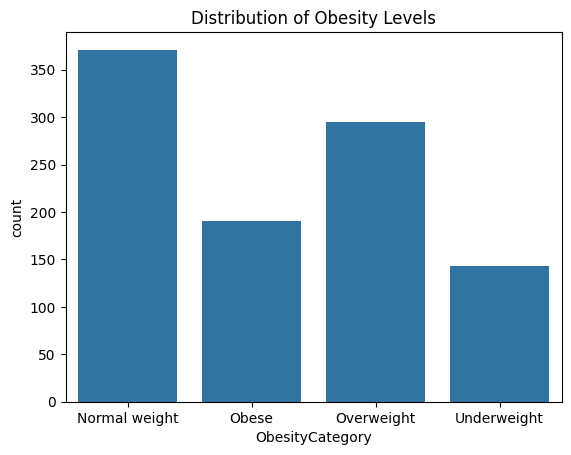

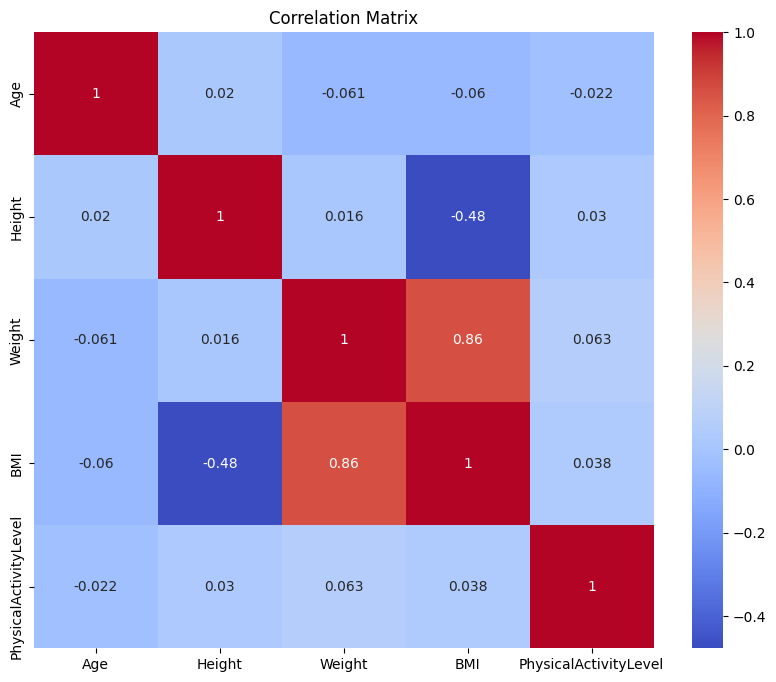

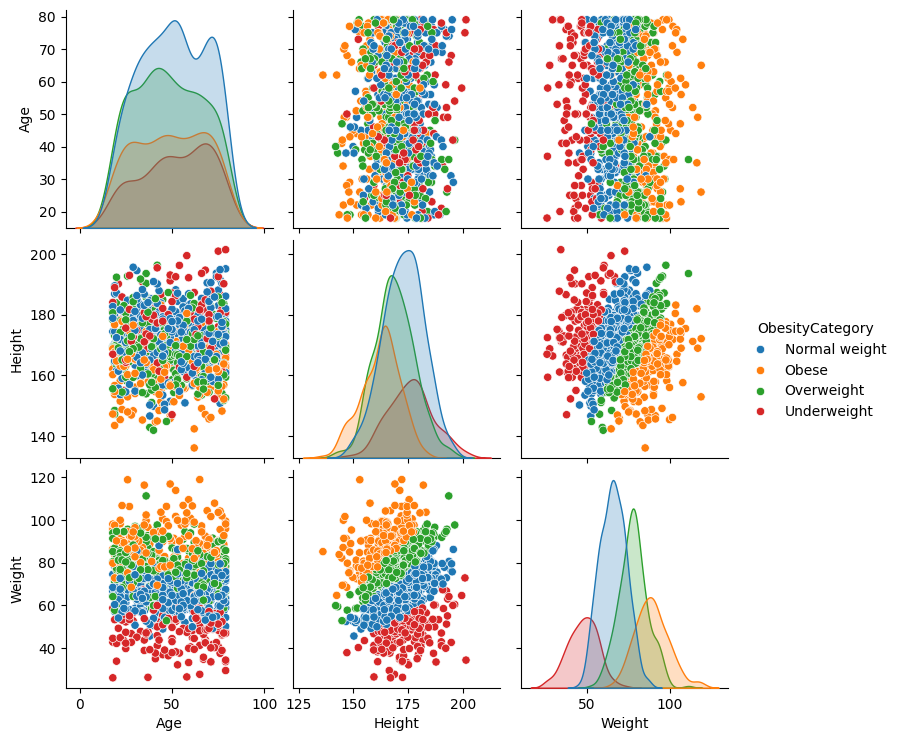

In [17]:
# Visualize the distribution of the target variable
sns.countplot(x=y)
plt.title("Distribution of Obesity Levels")
plt.show()

# Correlation matrix to check relationships between features
# Select only numerical features for correlation analysis
numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Pairplot for selected features
# Select relevant columns or a subset for visualization based on your dataset
sns.pairplot(data[['Age', 'Height', 'Weight', 'ObesityCategory']], hue='ObesityCategory')
plt.show()

In [19]:
# Select top features using SelectKBest
selector = SelectKBest(f_classif, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
# Get feature names from the preprocessor pipeline
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

# Use the feature names and get_support to get the selected feature names
selected_features = [feature_names[i] for i in range(len(feature_names)) if selector.get_support()[i]]

print("Selected Features:", selected_features)


Selected Features: ['Age', 'Height', 'Weight', 'BMI', 'Gender_Male']


In [21]:
# Initialize models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42)
}

# Cross-validation and performance comparison
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f}")

RandomForest Cross-Validation Accuracy: 0.9938
LogisticRegression Cross-Validation Accuracy: 0.9788
SVM Cross-Validation Accuracy: 0.9750


In [23]:
# Hyperparameter tuning for RandomForest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_



Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [24]:
# Predictions on test set
y_pred = best_model.predict(X_test_selected)

# Performance metrics
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 1.0
Classification Report:
                precision    recall  f1-score   support

Normal weight       1.00      1.00      1.00        72
        Obese       1.00      1.00      1.00        32
   Overweight       1.00      1.00      1.00        65
  Underweight       1.00      1.00      1.00        31

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
 [[72  0  0  0]
 [ 0 32  0  0]
 [ 0  0 65  0]
 [ 0  0  0 31]]


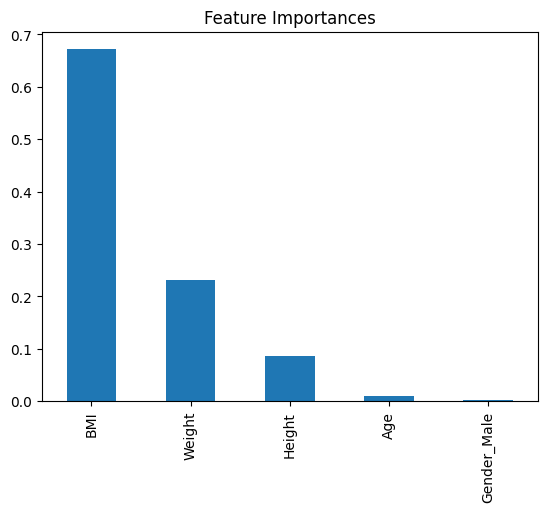

In [25]:
# Feature importance (only works for tree-based models like RandomForest)
importances = best_model.feature_importances_
feature_importances = pd.Series(importances, index=selected_features).sort_values(ascending=False)

# Plot feature importances
feature_importances.plot(kind='bar')
plt.title("Feature Importances")
plt.show()
